In [53]:
#Imports
import numpy as np
import sklearn as sk
import edward as ed
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup plotting
%matplotlib inline
np.random.seed(sum(map(ord, 'aesthetics')))
sns.set_style('ticks')
sns.set_context('paper', font_scale=2, rc={'lines.linewidth': 2.5})

# Setup Edward
#ed.set_seed(42)

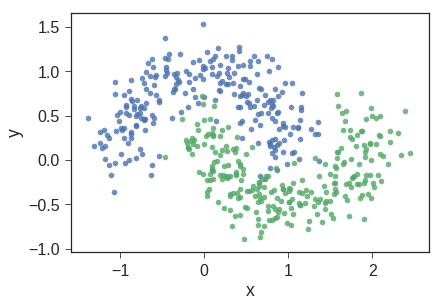

In [54]:
# Build a toy dataset
def build_toy_dataset(N=1000, noise=0.2):
    from sklearn import datasets
    from sklearn import model_selection
    X, Y = datasets.make_moons(noise=noise, random_state=0, n_samples=N)
    x_tr, x_te, y_tr, y_te = model_selection.train_test_split(X, Y, test_size=.5)
    return x_tr, x_te, y_tr, y_te

X_train, X_test, Y_train, Y_test = build_toy_dataset()
sns.regplot(data=pd.DataFrame.from_records(X_train[Y_train == 0], columns=['x', 'y']), x='x', y='y', fit_reg=False)
sns.regplot(data=pd.DataFrame.from_records(X_train[Y_train == 1], columns=['x', 'y']), x='x', y='y', fit_reg=False)
Y_train = [[1, 0] if i ==0 else [0, 1] for i in Y_train]
Y_test = [[1, 0] if i ==0 else [0, 1] for i in Y_test]

In [55]:
# Setup Neural Network
class MultilayerPerceptron:    
    def __init__(self, ninputs, nclasses, layerconfig):
        self.x = tf.placeholder(tf.float32, [None, ninputs])
        self.y = tf.placeholder(tf.float32, [None, nclasses])
        n = [ninputs] + layerconfig + [nclasses]
        self.w = [tf.Variable(tf.random_normal([n[i], n[i+1]]), name="w%d"%(i)) for i in range(0, len(n)-1)]
        self.b = [tf.Variable(tf.random_normal([l]), name="b%d"%(i)) for i,l in enumerate(n[1:])]
        self.model = self._network(self.x, self.w, self.b)
        
    def _network(self, x, w, b):
        xi = x
        for i, (wi, bi) in enumerate(zip(w, b)):
            xi = tf.nn.relu(tf.matmul(xi, wi) + bi)
        return tf.nn.softmax(xi)
        
    def train(self, X, Y, epochs=100, batch_size=100):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.model, labels=self.y))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(epochs):
            avg_cost = 0.
            total_batch = int(len(X)/batch_size)
            for batch_x, batch_y in zip(np.array_split(X, total_batch), np.array_split(Y, total_batch)):
                _, c = sess.run([optimizer, cost], feed_dict={self.x: batch_x, self.y: batch_y})
                avg_cost += c / total_batch
            if epoch % 1000 == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    
    def test(self, X, Y):
        correct_prediction = tf.equal(tf.argmax(self.model, 1), tf.argmax(self.y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        return accuracy.eval({self.x: X, self.y: Y})
    
    def classify(self, X):
        return tf.argmax(self.model, 1).eval({self.x: X})
    
    def get_weights(self):
        return tf.trainable_variables()
    
    def inject_values(self, var, session, value):
        op = tf.assign(var, value)
        session.run(op)

Epoch: 0001 cost= 0.787119269
Accuracy 95.59999704360962


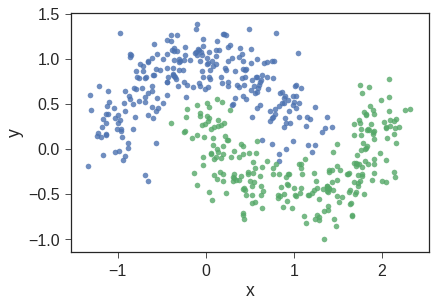

Accuracy 94.40000057220459


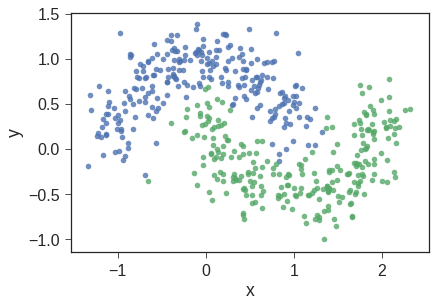

In [68]:
# Run classifier
with tf.Session() as sess:
    net = MultilayerPerceptron(2, 2, [20, 20])
    net.train(X_train, Y_train, 1000, 300)
    print("Accuracy", net.test(X_test, Y_test)*100)
    classes = net.classify(X_test)
    sns.regplot(data=pd.DataFrame.from_records(X_test[classes == 0], columns=['x', 'y']), x='x', y='y', fit_reg=False)
    sns.regplot(data=pd.DataFrame.from_records(X_test[classes == 1], columns=['x', 'y']), x='x', y='y', fit_reg=False)
    plt.show()
    
    # Inject errors and find
    for v in net.get_weights():
        net.inject_values(v, sess, v.eval()*5)
    print("Accuracy", net.test(X_test, Y_test)*100)
    classes = net.classify(X_test)
    sns.regplot(data=pd.DataFrame.from_records(X_test[classes == 0], columns=['x', 'y']), x='x', y='y', fit_reg=False)
    sns.regplot(data=pd.DataFrame.from_records(X_test[classes == 1], columns=['x', 'y']), x='x', y='y', fit_reg=False)
    plt.show()

In [72]:
# Run classifier
with tf.Session() as sess:
    net = MultilayerPerceptron(2, 2, [20, 10, 20, 10])
    net.train(X_train, Y_train, 1000, 300)
    print("Accuracy", net.test(X_test, Y_test)*100)
    print([v.name for v in net.get_weights()])

Epoch: 0001 cost= 0.838583231
Accuracy 48.80000054836273
['Variable:0', 'Variable_1:0', 'Variable_2:0', 'Variable_3:0', 'Variable_4:0', 'Variable_5:0', 'w0:0', 'w1:0', 'w2:0', 'b20:0', 'b20_1:0', 'b2:0', 'w0_1:0', 'w1_1:0', 'w2_1:0', 'b20_2:0', 'b20_3:0', 'b2_1:0', 'w0_2:0', 'w1_2:0', 'w2_2:0', 'b20_4:0', 'b20_5:0', 'b2_2:0', 'w0_3:0', 'w1_3:0', 'w2_3:0', 'b20_6:0', 'b20_7:0', 'b2_3:0', 'w0_4:0', 'w1_4:0', 'w2_4:0', 'b0:0', 'b1:0', 'b2_4:0', 'w0_5:0', 'w1_5:0', 'w2_5:0', 'b0_1:0', 'b1_1:0', 'b2_5:0', 'w0_6:0', 'w1_6:0', 'w2_6:0', 'b0_2:0', 'b1_2:0', 'b2_6:0', 'w0_7:0', 'w1_7:0', 'w2_7:0', 'b0_3:0', 'b1_3:0', 'b2_7:0', 'w0_8:0', 'w1_8:0', 'w2_8:0', 'b0_4:0', 'b1_4:0', 'b2_8:0', 'w0_9:0', 'w1_9:0', 'w2_9:0', 'b0_5:0', 'b1_5:0', 'b2_9:0', 'w0_10:0', 'w1_10:0', 'w2_10:0', 'b0_6:0', 'b1_6:0', 'b2_10:0', 'w0_11:0', 'w1_11:0', 'w2_11:0', 'b0_7:0', 'b1_7:0', 'b2_11:0', 'w0_12:0', 'w1_12:0', 'w2_12:0', 'b0_8:0', 'b1_8:0', 'b2_12:0', 'w0_13:0', 'w1_13:0', 'w2_13:0', 'b0_9:0', 'b1_9:0', 'b2_13:0'